In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from Preprocessing.preprocessing_sorted import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd
import pickle
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
#static parameters
train_batch_size = 30
val_batch_size = 30
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [3]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
#network_input, network_output = network_input.cuda(), network_output.cuda()
max_midi_number
# print(network_input)
#print(network_output)

89

In [ ]:
# network_input = pd.read_csv('Preprocessing\\network_input.csv')
# network_output = pd.read_csv('Preprocessing\\network_output.csv')

# network_input = np.asarray(network_input.values.tolist())
# network_input = torch.Tensor(network_input.reshape(network_input.shape[0], network_input.shape[1],1)).cuda()

# network_output = np.array(network_output.values.tolist())
# network_output = torch.Tensor(network_output.reshape(network_output.shape[0], )).cuda()

# max_midi_number = 105
# min_midi_number = 24

# # write python dict to a file
# # output = open('int_to_note.pkl', 'wb')
# # pickle.dump(int_to_note, output)
# # output.close()

# # read python dict back from the file
# # pkl_file = open('int_to_note.pkl', 'rb')
# # int_to_note = pickle.load(pkl_file)
# # pkl_file.close()

# int_to_note = {0: 24, 1: 26, 2: 27, 3: 28, 4: 29, 5: 30, 6: 31, 7: 32, 8: 33, 9: 34, 10: 35, 11: 36, 12: 37, 13: 38, 14: 39, 15: 40, 16: 41, 17: 42, 18: 43, 19: 44, 20: 45, 21: 46, 22: 47, 23: 48, 24: 49, 25: 50, 26: 51, 27: 52, 28: 53, 29: 54, 30: 55, 31: 56, 32: 57, 33: 58, 34: 59, 35: 60, 36: 61, 37: 62, 38: 63, 39: 64, 40: 65, 41: 66, 42: 67, 43: 68, 44: 69, 45: 70, 46: 71, 47: 72, 48: 73, 49: 74, 50: 75, 51: 76, 52: 77, 53: 78, 54: 79, 55: 80, 56: 81, 57: 82, 58: 83, 59: 84, 60: 85, 61: 86, 62: 87, 63: 88, 64: 89, 65: 90, 66: 91, 67: 92, 68: 93, 69: 94, 70: 95, 71: 96, 72: 97, 73: 98, 74: 99, 75: 100, 76: 101, 77: 102, 78: 103, 79: 104, 80: 105}

In [ ]:
#sns.distplot(network_output.cpu().numpy())

In [ ]:
network_input.shape

In [ ]:
# #network_input.cpu()
# network_output.cpu()

In [ ]:
print(network_output.max())
print(network_output.min())

In [ ]:
#torch.save(network_input, 'network_input.pt')
#torch.save(network_output, 'network_output.pt')

In [ ]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

In [ ]:
# '''
# data is highly unbalanced
# # '''
# sns.distplot(torch.tensor(network_output).cpu())
# xx = pd.DataFrame(torch.tensor(network_output).cpu())
# xx.groupby(0).size().to_frame(name='values')

In [4]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -29]
network_output = network_output[: -29]

print(network_input.shape)
print(network_output.shape)

torch.Size([1800, 50, 1])
torch.Size([1800])


In [5]:
network_input=network_input.cpu().numpy().tolist()
for i in range(len(network_input)):
    for j in range(len(network_input[i])):
        network_input[i][j][0]=((network_input[i][j][0])*(max_midi_number-min_midi_number)+min_midi_number)/max_midi_number
        

In [6]:
#network_input[0]
network_input=torch.Tensor(network_input).cuda()
network_output = network_output.cuda()

In [ ]:
#network_output[0]

In [7]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = hidden_size, hidden_size = output_size,batch_first = True)
        
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(output_size, output_size)
        
        
    def forward(self, x,batch_size):
        
        output, _ = self.lstm1(x)        
        #print(output.shape)
        
        output = self.dropout(output)
        
        output, _ = self.lstm2(output)
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, 38)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

    

In [8]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [9]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [10]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [11]:
#hidden = model.hidden_init(train_batch_size) 
#hidden

In [44]:
epochs = 500
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        
        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output = model.forward(inputs,train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        output = model.forward(inputs, val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256-38-removed_Ht_Ct_sorted_bakchodi.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 1.2645978 	Val Loss:0.9707082 	Train Acc: 57.56944% 	Val Acc: 70.5555556%
Validation Loss decreased from    inf to 0.970708, saving the model weights
Epoch: 1	Train Loss: 1.3393723 	Val Loss:0.9949946 	Train Acc: 55.69445% 	Val Acc: 71.6666666%
Epoch: 2	Train Loss: 1.2654560 	Val Loss:0.9348783 	Train Acc: 57.22222% 	Val Acc: 70.8333333%
Validation Loss decreased from 0.970708 to 0.934878, saving the model weights
Epoch: 3	Train Loss: 1.2618748 	Val Loss:0.9262026 	Train Acc: 57.15278% 	Val Acc: 71.6666676%
Validation Loss decreased from 0.934878 to 0.926203, saving the model weights
Epoch: 4	Train Loss: 1.2413444 	Val Loss:0.9051066 	Train Acc: 58.40278% 	Val Acc: 75.0000000%
Validation Loss decreased from 0.926203 to 0.905107, saving the model weights
Epoch: 5	Train Loss: 1.3182248 	Val Loss:0.9494268 	Train Acc: 54.79167% 	Val Acc: 74.1666675%
Epoch: 6	Train Loss: 1.3926869 	Val Loss:0.9550368 	Train Acc: 53.125% 	Val Acc: 70.2777783%
Epoch: 7	Train Loss: 1.2501

Epoch: 71	Train Loss: 1.2292915 	Val Loss:0.7536046 	Train Acc: 57.98611% 	Val Acc: 79.7222217%
Epoch: 72	Train Loss: 1.1839415 	Val Loss:0.7755784 	Train Acc: 59.51389% 	Val Acc: 78.0555561%
Epoch: 73	Train Loss: 1.0997096 	Val Loss:0.7340276 	Train Acc: 61.45833% 	Val Acc: 78.6111116%
Epoch: 74	Train Loss: 1.0491783 	Val Loss:0.6659463 	Train Acc: 64.58333% 	Val Acc: 82.2222218%
Epoch: 75	Train Loss: 0.9897395 	Val Loss:0.6486198 	Train Acc: 68.26389% 	Val Acc: 81.3888893%
Epoch: 76	Train Loss: 1.0182517 	Val Loss:0.6332455 	Train Acc: 67.01389% 	Val Acc: 85.2777764%
Epoch: 77	Train Loss: 1.0120300 	Val Loss:0.6244712 	Train Acc: 65.69444% 	Val Acc: 83.0555538%
Validation Loss decreased from 0.628603 to 0.624471, saving the model weights
Epoch: 78	Train Loss: 1.0423971 	Val Loss:0.6675322 	Train Acc: 65.55556% 	Val Acc: 82.7777768%
Epoch: 79	Train Loss: 1.0048253 	Val Loss:0.6160081 	Train Acc: 66.66667% 	Val Acc: 84.1666654%
Validation Loss decreased from 0.624471 to 0.616008, savin

Epoch: 147	Train Loss: 0.8694122 	Val Loss:0.4139222 	Train Acc: 70.55556% 	Val Acc: 91.6666667%
Validation Loss decreased from 0.423649 to 0.413922, saving the model weights
Epoch: 148	Train Loss: 0.8576035 	Val Loss:0.4395203 	Train Acc: 71.18056% 	Val Acc: 89.7222211%
Epoch: 149	Train Loss: 0.8674134 	Val Loss:0.3996689 	Train Acc: 71.11111% 	Val Acc: 91.3888877%
Validation Loss decreased from 0.413922 to 0.399669, saving the model weights
Epoch: 150	Train Loss: 0.9121439 	Val Loss:0.4595675 	Train Acc: 69.51389% 	Val Acc: 88.6111105%
Epoch: 151	Train Loss: 0.8672499 	Val Loss:0.4401040 	Train Acc: 72.29167% 	Val Acc: 89.1666661%
Epoch: 152	Train Loss: 0.9015151 	Val Loss:0.4677584 	Train Acc: 70.0% 	Val Acc: 88.3333330%
Epoch: 153	Train Loss: 0.8639064 	Val Loss:0.4539668 	Train Acc: 70.34722% 	Val Acc: 89.4444431%
Epoch: 154	Train Loss: 0.8605737 	Val Loss:0.4757489 	Train Acc: 70.83333% 	Val Acc: 87.7777775%
Epoch: 155	Train Loss: 0.8661614 	Val Loss:0.4172995 	Train Acc: 72.3611

Epoch: 225	Train Loss: 0.9098245 	Val Loss:0.3917331 	Train Acc: 69.51389% 	Val Acc: 90.2777766%
Epoch: 226	Train Loss: 1.3257489 	Val Loss:0.7710239 	Train Acc: 59.23611% 	Val Acc: 74.1666665%
Epoch: 227	Train Loss: 1.4914852 	Val Loss:0.5386586 	Train Acc: 53.05556% 	Val Acc: 86.3888885%
Epoch: 228	Train Loss: 0.9230459 	Val Loss:0.4068118 	Train Acc: 68.81944% 	Val Acc: 89.7222221%
Epoch: 229	Train Loss: 0.8684745 	Val Loss:0.3733161 	Train Acc: 70.625% 	Val Acc: 89.9999996%
Epoch: 230	Train Loss: 0.7669512 	Val Loss:0.3945430 	Train Acc: 74.65278% 	Val Acc: 88.6111110%
Epoch: 231	Train Loss: 0.7279831 	Val Loss:0.3654618 	Train Acc: 75.97222% 	Val Acc: 91.6666652%
Epoch: 232	Train Loss: 0.7282717 	Val Loss:0.3064664 	Train Acc: 74.93056% 	Val Acc: 94.4444443%
Validation Loss decreased from 0.317119 to 0.306466, saving the model weights
Epoch: 233	Train Loss: 0.7390649 	Val Loss:0.3251266 	Train Acc: 75.76389% 	Val Acc: 92.4999997%
Epoch: 234	Train Loss: 0.7453374 	Val Loss:0.460832

Epoch: 303	Train Loss: 1.0505418 	Val Loss:0.6249087 	Train Acc: 67.29167% 	Val Acc: 81.9444443%
Epoch: 304	Train Loss: 0.8376162 	Val Loss:0.4954547 	Train Acc: 73.05556% 	Val Acc: 84.7222209%
Epoch: 305	Train Loss: 0.7213805 	Val Loss:0.3442518 	Train Acc: 76.04167% 	Val Acc: 89.9999996%
Epoch: 306	Train Loss: 0.6822608 	Val Loss:0.2428210 	Train Acc: 77.36111% 	Val Acc: 94.9999998%
Epoch: 307	Train Loss: 0.6311886 	Val Loss:0.2203818 	Train Acc: 79.02778% 	Val Acc: 95.2777778%
Validation Loss decreased from 0.228340 to 0.220382, saving the model weights
Epoch: 308	Train Loss: 0.6089911 	Val Loss:0.2232833 	Train Acc: 79.44444% 	Val Acc: 94.4444438%
Epoch: 309	Train Loss: 0.6039653 	Val Loss:0.2136797 	Train Acc: 80.06944% 	Val Acc: 94.1666668%
Validation Loss decreased from 0.220382 to 0.213680, saving the model weights
Epoch: 310	Train Loss: 0.5861934 	Val Loss:0.2319666 	Train Acc: 80.90278% 	Val Acc: 95.5555558%
Epoch: 311	Train Loss: 0.6020006 	Val Loss:0.2202156 	Train Acc: 80.

Epoch: 378	Train Loss: 0.6230504 	Val Loss:0.1757221 	Train Acc: 79.93056% 	Val Acc: 95.5555548%
Epoch: 379	Train Loss: 0.5210872 	Val Loss:0.1679041 	Train Acc: 83.125% 	Val Acc: 95.8333328%
Epoch: 380	Train Loss: 0.5073267 	Val Loss:0.1534587 	Train Acc: 83.68055% 	Val Acc: 95.5555553%
Epoch: 381	Train Loss: 0.4648797 	Val Loss:0.1570263 	Train Acc: 85.55555% 	Val Acc: 95.2777768%
Epoch: 382	Train Loss: 0.4941805 	Val Loss:0.1613626 	Train Acc: 84.44444% 	Val Acc: 94.9999993%
Epoch: 383	Train Loss: 0.4752895 	Val Loss:0.1408441 	Train Acc: 84.51389% 	Val Acc: 95.5555553%
Validation Loss decreased from 0.149983 to 0.140844, saving the model weights
Epoch: 384	Train Loss: 0.4832541 	Val Loss:0.1583338 	Train Acc: 83.75% 	Val Acc: 95.5555553%
Epoch: 385	Train Loss: 0.4560885 	Val Loss:0.1634179 	Train Acc: 85.34722% 	Val Acc: 94.9999993%
Epoch: 386	Train Loss: 0.4727408 	Val Loss:0.1415558 	Train Acc: 84.09722% 	Val Acc: 96.3888884%
Epoch: 387	Train Loss: 0.4488361 	Val Loss:0.1498651 	

Epoch: 456	Train Loss: 0.4569264 	Val Loss:0.1202643 	Train Acc: 84.79167% 	Val Acc: 96.1111108%
Epoch: 457	Train Loss: 0.4264794 	Val Loss:0.1384040 	Train Acc: 86.25% 	Val Acc: 96.1111108%
Epoch: 458	Train Loss: 0.4142486 	Val Loss:0.1345364 	Train Acc: 86.18055% 	Val Acc: 96.6666664%
Epoch: 459	Train Loss: 0.3954180 	Val Loss:0.1034336 	Train Acc: 85.34722% 	Val Acc: 97.2222219%
Epoch: 460	Train Loss: 0.3634685 	Val Loss:0.1039453 	Train Acc: 88.47222% 	Val Acc: 96.9444439%
Epoch: 461	Train Loss: 0.4059288 	Val Loss:0.1237031 	Train Acc: 86.66667% 	Val Acc: 96.3888889%
Epoch: 462	Train Loss: 0.4474399 	Val Loss:0.1373602 	Train Acc: 86.25% 	Val Acc: 95.8333328%
Epoch: 463	Train Loss: 0.3986889 	Val Loss:0.1006763 	Train Acc: 87.5% 	Val Acc: 96.9444439%
Epoch: 464	Train Loss: 0.3655937 	Val Loss:0.1019153 	Train Acc: 88.125% 	Val Acc: 96.9444444%
Epoch: 465	Train Loss: 0.3628641 	Val Loss:0.0944208 	Train Acc: 88.81944% 	Val Acc: 96.6666664%
Validation Loss decreased from 0.099413 to

## MUSIC GENERATION

In [45]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256-38-removed_Ht_Ct_sorted_bakchodi.pt'))
test_model.eval()
test_model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [54]:
#load population database
testing_data = np.ones(200)*0
# testing_data = list(range(50,89))
# testing_data.extend(testing_data[::-1])
# testing_data_rev = testing_data[::-1]
# testing_data_rev.extend(testing_data)
# testing_data_rev.extend(testing_data_rev)
# testing_data = testing_data_rev


testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

testing_data_unnorm = testing_data

In [47]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    #list1[i]=(list1[i]-50)/(89-50)
    list1[i]=(list1[i])/(89)


list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [48]:
#testing_data

In [55]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, min_note, test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
                
        
        test_output = test_model.forward(test_slice, test_batch_size)
    
        test_output = F.softmax(test_output, dim = 1)
        top_p, top_class = test_output.topk(1,dim =1)
        
        #test_seq[0][sequence_length - 1 + i][0] = (int2note[top_class.item()] - min_note)/(max_note - min_note)
        test_seq[0][sequence_length - 1 + i][0] = (int2note[top_class.item()] )/(max_note)

   
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [56]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number, min_midi_number)

In [51]:
#predicted_notes_lst

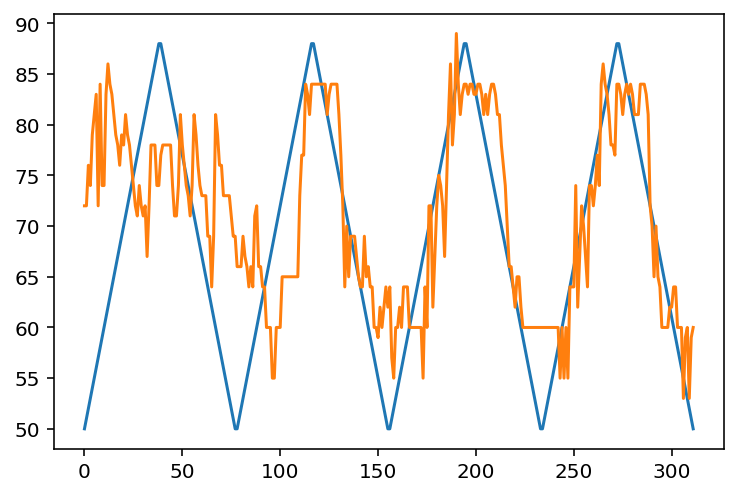

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.plot(list(np.ones(200)*24))

#plt.plot(list(np.ones(200)*89))
plt.plot(list(np.ones(200)*50))
plt.plot(testing_data_unnorm)
plt.plot(predicted_notes_lst)

In [53]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({72: 16,
         76: 8,
         74: 20,
         79: 6,
         81: 22,
         83: 19,
         84: 33,
         86: 3,
         78: 16,
         71: 7,
         67: 7,
         77: 6,
         73: 9,
         69: 10,
         64: 24,
         66: 10,
         60: 50,
         55: 7,
         65: 16,
         70: 5,
         59: 3,
         62: 10,
         57: 1,
         75: 1,
         89: 1,
         53: 2})